In [11]:
import numpy as np, GPy, pandas as pd
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# Trajectory Simulation

We want to simulate a trajectory for the latent space with a long lengthscale and some
minor small variations:

In [12]:
import time, os
from run_method_comparison import run_results, seeds, methods, collect_results
from plot_definitions_datasets import plot_simulation_results_preliminary
from topslam.simulation import guo_simulation

In [17]:
def run_bgplvm(Y, X_init):
    Q = max(5, X_init.shape[1])
    X = np.random.normal(0,1,(X_init.shape[0], Q))
    X[:,:X_init.shape[1]] = X_init[:, :X.shape[1]]
    m = GPy.models.BayesianGPLVM(Y, Q, 
                                 kernel=GPy.kern.RBF(Q, ARD=True),
                                     X=X,
                                     num_inducing=25)

    m.update_model(False)
    m.likelihood[:] = Y.var()/10.
    m.X.variance[:] = .1
    m.kern.lengthscale.fix()
    m.likelihood.fix()
    #m.X.mean.fix()
    m.update_model(True)
    
    mes = 0
    m.optimize(max_iters=500, messages=mes, clear_after_finish=True)

    m.likelihood.unfix()
    m.optimize(max_iters=500, messages=mes, clear_after_finish=True)

    m.kern.lengthscale.unfix()
    m.optimize(max_iters=1e5, messages=mes, clear_after_finish=True) 
    return m

In [3]:
res_name = 'trajectory_for_each_method_no_optimize_all'
folder = '../supplementary/{}'.format(res_name)
if not os.path.exists(folder):
    os.makedirs(folder)

In [19]:
(Xsim_results_collection, 
 time_results_collection,
 runtime_collection, 
 ard_collection, 
 method_results_collection, 
 model_collection,
 pt_collection) = run_results(run_bgplvm, guo_simulation, 
                              '../diagrams/simulation/{}'.format(res_name), for_each_method=True)

SLS8971...
  Iteration 0 1 2 3 4 5 6 7 8 9
SLS3551...
  Iteration 0 1 2 3 4 5 6 7 8 9
SLS3279...
  Iteration 0 1 2 3 4 5 6 7 8 9
SLS5001...
  Iteration 0 1 2 3 4 5 6 7 8 9
SLS5081...
  Iteration 0 1 2 3 4 5 6 7 8 9


In [1]:
import os

# Collect results:
n_repeats = len(pt_collection)/len(seeds)

rvalues = collect_results(pt_collection, 'rvalue', n_repeats)
rvalues.to_csv(os.path.join(folder, '{}.csv'.format('time_rvalue')))
fig, first = plot_simulation_results_preliminary(rvalues)
fig.suptitle("Time r-values")
fig.savefig('../diagrams/simulation/{}/{}.pdf'.format(res_name, 'time_rvalue'))


time_errors = collect_results(time_results_collection, 'NRMSE', n_repeats)
time_errors.to_csv(os.path.join(folder, '{}.csv'.format('time')))
fig, first = plot_simulation_results_preliminary(time_errors)
fig.suptitle("Time errors NRMSE")
fig.savefig('../diagrams/simulation/{}/{}.pdf'.format(res_name, 'time'))


Xsim_errors = collect_results(Xsim_results_collection, 'NRMSE', n_repeats)
Xsim_errors.to_csv(os.path.join(folder, '{}.csv'.format('Xsim')))
fig, first = plot_simulation_results_preliminary(Xsim_errors)
fig.suptitle("Xsim errors NRMSE")
fig.savefig('../diagrams/simulation/{}/{}.pdf'.format(res_name, 'Xsim'))

NameError: name 'pt_collection' is not defined

In [20]:
import pandas as pd
rvalues = pd.read_csv(os.path.join(folder, '{}.csv'.format('time_rvalue')), index_col=[0,1,2,3])

method_names = rvalues.index.get_level_values(2)

new_names = []
for name in method_names:
    split = name.split('+')
    if len(split) == 2:
        new_names.append([split[0], 'topslam'])
    else:
        new_names.append(split+['alone'])
new_names, topslam = zip(*new_names)

tmp = rvalues.reset_index()
tmp['method'] = new_names
tmp['corrected'] = topslam
tmp['corrected categorical'] = pd.Categorical(tmp['corrected']).codes
tmp = tmp.set_index(['latent space', 'data simulation', 'method', 'corrected', 'corrected categorical'])
tmp = tmp.stack()
tmp.index = tmp.index.set_names(['latent space', 'data simulation', 'method', 'corrected', 'corrected categorical', 'graph correction'])
tmp = tmp.reset_index()
tmp.columns = [    u'latent space',  u'data simulation',           u'method',
              u'corrected', 'corrected categorical', u'graph correction',                   'rvalue']

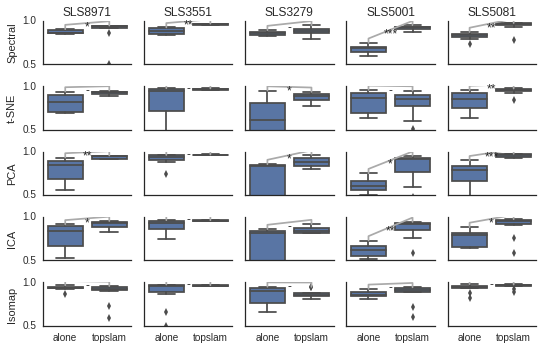

In [22]:
def stars(p):
    if p < 0.0001:
        return "****"
    elif (p < 0.001):
        return "***"
    elif (p < 0.01):
        return "**"
    elif (p < 0.05):
        return "*"
    else:
        return "-"
    
with sns.axes_style("white", rc={'font.sans-serif': [u'Arial','Arno Pro','Liberation Sans']}):
    row_order = methods.keys()
    g = sns.FacetGrid(data=tmp.set_index('graph correction', append=True).xs('Tree Corrected', level=1),
                      row='method', col='latent space', size=1, row_order=row_order, col_order=seeds, 
                      palette=sns.color_palette('muted'), margin_titles=False,
                     aspect=1.5)
    def boxplot(x, y, **kwargs):
        kwargs.pop('label', None)
        return sns.boxplot(x, y, **kwargs)
    def annotate(x, y, data=None, **kwargs):
        df = pd.concat((x,y), axis=1)
        g = df.groupby(df.columns[0])
        (_, x), (_, y) = g
        x, y = x['rvalue'], y['rvalue']
        x_min, x_max = x.min(), x.max()
        y_min, y_max = y.min(), y.max()
        from scipy.stats import mannwhitneyu
        z, p = mannwhitneyu(x, y)
        p_value = p * 2
        ax = plt.gca()
        
        # Connector:
        connector = np.array([(0,x_max), (0,x_max+.05), (1,y_max+.05), (1,y_max)])
        plt.plot(*connector.T, color='#aaaaaa')
        ax.text(.5, (y_max+x_max)/2, stars(p_value),
               horizontalalignment='center',
               verticalalignment='center', transform=ax.transData)
    g.map(boxplot, 'corrected', 'rvalue')
    g.map(annotate, 'corrected', 'rvalue')

    for r in range(g.axes.shape[0]):
        for c in range(g.axes.shape[1]):
            a = g.axes[r,c]
            if r == 0: a.set_title('SLS{}'.format(seeds[c]))
            else: a.set_title('')
            if c == 0: a.set_ylabel('{}'.format(row_order[r]))
            a.set_xlabel('')
            a.set_ylim(.5,1)
            a.set_yticks([.5, 1])
    g.fig.tight_layout(rect=(.04,0,1,1))
    g.fig.savefig('../diagrams/simulation/{}/{}.pdf'.format(res_name, 'rvalue_comparisons.pdf'), transparent=True, bbox='tight')